## Pair Programming
#### This file is the first version of the project, topic: cat, dog, work search terms on a Friday.
#### For weekly cross check and efficient code review, we wrote two versions code, same structure with different methods and examples. Thus not only help us improve our programming level, but also hope to provide more references for other developers.

In [4]:
import scipy.stats
import re
from csv import reader, writer, DictWriter
import json
import collections

# PART 1 - Working with Texts and Sentiments

## 1A - Parsing the Raw Tweets Texts

In [5]:
def extract_words(text):
    """
    Takes a string of text and returns a list of the words in the string.

    >>> extract_words("It doesn't take long for a dog to win over a person's heart. The scene opens with a young boy's eyes glued to a... https://t.co/zjVLUk2afA")
    ['it', "doesn't", 'take', 'long', 'for', 'a', 'dog', 'to', 'win', 'over', 'a', "person's", 'heart', 'the', 'scene', 'opens', 'with', 'a', 'young', "boy's", 'eyes', 'glued', 'to', 'a', 'https', 't', 'co', 'zjvluk', 'afa']

    """
    words = re.split("[^a-zA-Z'_-]", text)
    words_list = list(filter(None, words))  # remove empty strings!
    words_lower = list()
    for word in words_list:
        # make it all lowercase to match sentiment files
        words_lower.append(word.lower())
    return words_lower

In [6]:
extract_words("It doesn't take long for a dog to win over a person's heart. The scene opens with a young boy's eyes glued to a... https://t.co/zjVLUk2afA")

['it',
 "doesn't",
 'take',
 'long',
 'for',
 'a',
 'dog',
 'to',
 'win',
 'over',
 'a',
 "person's",
 'heart',
 'the',
 'scene',
 'opens',
 'with',
 'a',
 'young',
 "boy's",
 'eyes',
 'glued',
 'to',
 'a',
 'https',
 't',
 'co',
 'zjvluk',
 'afa']

## 1B - Using an Objective Sentiment Dictionary

In [7]:
def load_sentiments(senti_file):
    """
    takes in the name of a file containing the word sentiment scores, and return a dictionary. The keys are the words and the values are the numeric scores of the words.

    """
    # {words: numeric scores}
    senti_dic = {}
    with open(senti_file) as file:
        csv_reader = reader(file)
        for item in csv_reader:
            senti_dic[item[0]] = float(item[1])
    return senti_dic

In [8]:
location = %pwd
print(location)

C:\Users\Gilkey\Desktop\Twitter Sentiment - Jupyter


In [9]:
sentiment_file = location + "\AFINN-111.csv"
print(sentiment_file)

C:\Users\Gilkey\Desktop\Twitter Sentiment - Jupyter\AFINN-111.csv


In [10]:
sentiment_dictionary = load_sentiments(sentiment_file)
print(sentiment_dictionary)

{'abandon': -2.0, 'abandoned': -2.0, 'abandons': -2.0, 'abducted': -2.0, 'abduction': -2.0, 'abductions': -2.0, 'abhor': -3.0, 'abhorred': -3.0, 'abhorrent': -3.0, 'abhors': -3.0, 'abilities': 2.0, 'ability': 2.0, 'aboard': 1.0, 'absentee': -1.0, 'absentees': -1.0, 'absolve': 2.0, 'absolved': 2.0, 'absolves': 2.0, 'absolving': 2.0, 'absorbed': 1.0, 'abuse': -3.0, 'abused': -3.0, 'abuses': -3.0, 'abusive': -3.0, 'accept': 1.0, 'accepted': 1.0, 'accepting': 1.0, 'accepts': 1.0, 'accident': -2.0, 'accidental': -2.0, 'accidentally': -2.0, 'accidents': -2.0, 'accomplish': 2.0, 'accomplished': 2.0, 'accomplishes': 2.0, 'accusation': -2.0, 'accusations': -2.0, 'accuse': -2.0, 'accused': -2.0, 'accuses': -2.0, 'accusing': -2.0, 'ache': -2.0, 'achievable': 1.0, 'aching': -2.0, 'acquit': 2.0, 'acquits': 2.0, 'acquitted': 2.0, 'acquitting': 2.0, 'acrimonious': -3.0, 'active': 1.0, 'adequate': 1.0, 'admire': 3.0, 'admired': 3.0, 'admires': 3.0, 'admiring': 3.0, 'admit': -1.0, 'admits': -1.0, 'admi

## 1C - Get the Sentiment Score of a "Clean" Sentence

In [11]:
def text_sentiment(text, senti_dic):
    """
    takes in the text (a string) to analyze, and a dictionary of word sentiment values. The function returns the sentiment of the string - the sum of the sentiments of the words in the string.
    >>> text_sentiment("I prefer the rain to sunshine", AFINN-111.csv)
    2.0

    """
    words = extract_words(text)
    sum_score = 0.0
    for word in words:
        if word in senti_dic:
            sum_score += senti_dic[word]
    return sum_score

In [12]:
text_sentiment("I prefer the rain to sunshine", sentiment_dictionary)

2.0

# PART 2 - Working with Twitter JSON Files

## Preparation - The "data" folder contains .txt files we downloaded for further analysis using "twitter_stream.py" and Twitter API from the terminal.
#### The filenames also contain our search terms when requesting those tweets, e.g.: "dog", "cat", and "work".
#### We've taken out our own ACCESS_TOKEN_KEY following Twitter's security protocols.

In [13]:
data_location = location + "\data"
print(data_location)

C:\Users\Gilkey\Desktop\Twitter Sentiment - Jupyter\data


In [14]:
twitter_stream_cat_file = data_location + "/cat.txt"
print(twitter_stream_cat_file)

C:\Users\Gilkey\Desktop\Twitter Sentiment - Jupyter\data/cat.txt


In [15]:
twitter_stream_dog_file = data_location + "/dog.txt"
print(twitter_stream_dog_file)

C:\Users\Gilkey\Desktop\Twitter Sentiment - Jupyter\data/dog.txt


In [16]:
twitter_stream_work_file = data_location + "/2021-12-03-work.txt"
print(twitter_stream_work_file)

C:\Users\Gilkey\Desktop\Twitter Sentiment - Jupyter\data/2021-12-03-work.txt


## 2A - Tidy up the Twitter Data from the JSON String.

In [17]:
def load_tweets(tweets_file):
    """Takes in the JSON formatted string, and returns a tidy list of dictionaries representing the tweets."""
    res = []
    with open(tweets_file) as file:
        for tweet in file:
            s = json.loads(tweet)
            d = {}
            # pass key info to d
            d['created_at'] = s['created_at']
            d['user_name'] = s['user']['screen_name']
            d['text'] = s['text']
            d['retweet_count'] = s['retweet_count']
            d['favorite_count'] = s['favorite_count']

            # dealing with possibly multiple hashtags
            d['entities.hashtags.text'] = []
            if s['entities']['hashtags']:                
                for hashtag in s['entities']['hashtags']:
                    d['entities.hashtags.text'].append(hashtag['text'].lower())
            res.append(d)
    return res

In [18]:
load_tweets(twitter_stream_cat_file)

[{'created_at': 'Fri Dec 03 18:59:59 +0000 2021',
  'user_name': 'gerard_furest',
  'text': 'RT @comuni_cats: “Ni permiso ni perdón” \n@pauetvidal \n\n“No és el títol de cap western sinó un lema per a l’empoderament lingüístic que apli…',
  'retweet_count': 2,
  'favorite_count': 0,
  'entities.hashtags.text': []},
 {'created_at': 'Fri Dec 03 18:59:59 +0000 2021',
  'user_name': 'DrugoJaa',
  'text': 'Doja Cat - Woman (Official Video) https://t.co/4y2RGKaFfR преко корисника @YouTube BOGINJA',
  'retweet_count': 0,
  'favorite_count': 0,
  'entities.hashtags.text': []},
 {'created_at': 'Fri Dec 03 18:59:59 +0000 2021',
  'user_name': 'TAAENIN',
  'text': 'RT @JvanRuiz: Cat move$ #6\nÓleo sobre papel joder https://t.co/I7GC4cnxtu',
  'retweet_count': 11824,
  'favorite_count': 0,
  'entities.hashtags.text': []},
 {'created_at': 'Fri Dec 03 18:59:59 +0000 2021',
  'user_name': 'nogueiha',
  'text': 'muito triste viver no mesmo mundo q a doja cat e ela não namorar comigo',
  'retweet_count

## 2B - Calculate Total Popularity from the JSON File

In [19]:
def popularity(tweets_file):
    """returns a tuple (average_number_of retweets, average_number_of_favorites) of the whole tweets_file"""
    data = load_tweets(tweets_file)
    count = len(data)
    retweets_sum, favorites_sum = 0, 0
    for d in data:
        retweets_sum += d['retweet_count']
        favorites_sum += d['favorite_count']
    return (retweets_sum / count, favorites_sum / count)

### It looks like "work" is the most popular among the Friday noon topics... Human care about themselves more than cute animals? 

In [20]:
cat_pop = popularity(twitter_stream_cat_file)
print(cat_pop)

(923.065, 0.008333333333333333)


In [21]:
dog_pop = popularity(twitter_stream_dog_file)
print(dog_pop)

(870.0283806343906, 0.018363939899833055)


In [22]:
work_pop = popularity(twitter_stream_work_file)
print(work_pop)

(1201.55, 0.0)


## What are the Trending Hashtags Related to These Topics?

# 2C - Trending Hashtags

In [23]:
def hashtag_counts(tweets_file):
    """return a list of tuples. (a hashtag, number of times the tag was used), the list is ordered by the decesending order of frequency.
    """
    data = load_tweets(tweets_file)
    freq = {}
    for d in data:
        if 'entities.hashtags.text' in d:
            hashtags = d['entities.hashtags.text']
            for hashtag_name in hashtags:
                if hashtag_name not in freq:
                    freq[hashtag_name] = 1
                else:
                    freq[hashtag_name] += 1
    res = []
    # first sort dict with frequency, then sort it with name.
    for hashtag, count in freq.items():
        res.append((count, hashtag))

    res.sort(reverse=True)
    sort_res = []
    for count, hashtag in res:
        sort_res.append(('#' + hashtag, count))

    return sort_res

In [24]:
hashtag_counts(twitter_stream_cat_file)

[('#cat', 9),
 ('#england', 6),
 ('#cats', 5),
 ('#rescue', 4),
 ('#warwickshire', 3),
 ('#plymouth', 3),
 ('#catsoftwitter', 3),
 ('#catsofinstagram', 3),
 ('#vtuber', 2),
 ('#themeowedclub', 2),
 ('#petsareforlife', 2),
 ('#meowedofficial', 2),
 ('#meowed', 2),
 ('#kittens', 2),
 ('#kitten', 2),
 ('#jeno', 2),
 ('#envtuber', 2),
 ('#adoptdontshop', 2),
 ('#도영이_벌스데이_햅삐햅삐로통통', 1),
 ('#轟百', 1),
 ('#猫', 1),
 ('#僕のヒーローアカデミア', 1),
 ('#ヴァニタスの手記', 1),
 ('#ドヨンちゃんおめでトントン', 1),
 ('#グラトリ', 1),
 ('#アズールレーン', 1),
 ('#แบนลูกหนัง', 1),
 ('#แบนลูกสลิ่ม', 1),
 ('#últimahora', 1),
 ('#yellowfang', 1),
 ('#yaoyorozumomo', 1),
 ('#xmasgift', 1),
 ('#xmas2021', 1),
 ('#win', 1),
 ('#wedness', 1),
 ('#wcotw', 1),
 ('#warriorcats', 1),
 ('#walls', 1),
 ('#vtuberuprising', 1),
 ('#vsdaveandbambi', 1),
 ('#vic', 1),
 ('#vanitasnocarte', 1),
 ('#trobasons', 1),
 ('#todorokishouto', 1),
 ('#todomomo', 1),
 ('#terrassa', 1),
 ('#solana', 1),
 ('#sleepycat', 1),
 ('#sitala', 1),
 ('#santafloki', 1),
 ('#sabadell'

In [25]:
hashtag_counts(twitter_stream_dog_file)

[('#england', 17),
 ('#ratchetps5', 16),
 ('#manchester', 8),
 ('#dog', 7),
 ('#scotland', 4),
 ('#edinburgh', 4),
 ('#dogs', 4),
 ('#worcestershire', 3),
 ('#uk', 3),
 ('#scanme', 3),
 ('#nyfcc', 3),
 ('#foxcub', 3),
 ('#cumbria', 3),
 ('#win', 2),
 ('#stolen', 2),
 ('#rspca', 2),
 ('#nycacc', 2),
 ('#lost', 2),
 ('#isleofwight', 2),
 ('#germanshepherd', 2),
 ('#dogcoin', 2),
 ('#countydurham', 2),
 ('#benedictcumberbatch', 2),
 ('#appleby', 2),
 ('#한국날짜로축하해야하는거죠', 1),
 ('#진심으로추카추카', 1),
 ('#진생일ㅊㅋ', 1),
 ('#진생일ᄎᄏ', 1),
 ('#슈가입니다', 1),
 ('#석진생일_gameday', 1),
 ('#석지니', 1),
 ('#김석진', 1),
 ('#デュオゲリラ', 1),
 ('#デュオ', 1),
 ('#θειος_ραδιουργος', 1),
 ('#whitby', 1),
 ('#westerngermany', 1),
 ('#wd4', 1),
 ('#walls', 1),
 ('#vivalasasha', 1),
 ('#vintage', 1),
 ('#urgent', 1),
 ('#urbanart', 1),
 ('#troublemaker', 1),
 ('#tn8', 1),
 ('#theblueprint', 1),
 ('#tax', 1),
 ('#takeflight22', 1),
 ('#streetart', 1),
 ('#smile', 1),
 ('#sitala', 1),
 ('#seniordog', 1),
 ('#selfcare', 1),
 ('#sashaban

# Part 3 - Working with Both Tweets and Sentiments

## 3A - What is the sentiment score for each tweet?

In [26]:
def tweet_sentiments(tweets_file, senti_file):
    """return a list of tweet objects, each tweet object should have an additional field - sentiment that holds the sentiment of the tweet's text. 
    Label the search_term for each tweets in the file."""
    list_of_tweet_objects = load_tweets(tweets_file)
    senti_dict = load_sentiments(senti_file)
    for obj in list_of_tweet_objects:
        score = text_sentiment(obj['text'], senti_dict)
        obj['sentiment'] = score
    return list_of_tweet_objects

In [27]:
list_of_cat_objects = tweet_sentiments(twitter_stream_cat_file, sentiment_file)
print(list_of_cat_objects)

[{'created_at': 'Fri Dec 03 18:59:59 +0000 2021', 'user_name': 'gerard_furest', 'text': 'RT @comuni_cats: “Ni permiso ni perdón” \n@pauetvidal \n\n“No és el títol de cap western sinó un lema per a l’empoderament lingüístic que apli…', 'retweet_count': 2, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': -1.0}, {'created_at': 'Fri Dec 03 18:59:59 +0000 2021', 'user_name': 'DrugoJaa', 'text': 'Doja Cat - Woman (Official Video) https://t.co/4y2RGKaFfR преко корисника @YouTube BOGINJA', 'retweet_count': 0, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': 0.0}, {'created_at': 'Fri Dec 03 18:59:59 +0000 2021', 'user_name': 'TAAENIN', 'text': 'RT @JvanRuiz: Cat move$ #6\nÓleo sobre papel joder https://t.co/I7GC4cnxtu', 'retweet_count': 11824, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': 0.0}, {'created_at': 'Fri Dec 03 18:59:59 +0000 2021', 'user_name': 'nogueiha', 'text': 'muito triste viver no mesmo mundo q a doja cat e ela não namorar comigo'

In [28]:
list_of_dog_objects = tweet_sentiments(twitter_stream_dog_file, sentiment_file)
print(list_of_dog_objects)

[{'created_at': 'Fri Dec 03 19:23:34 +0000 2021', 'user_name': 'TandGIreland', 'text': 'RT @TacticalDogLive: Rescue dog graduates from K9 program \n😀Congratulations, Lotus! Good luck and God bless to you and Officer John Colvin…', 'retweet_count': 4, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': 13.0}, {'created_at': 'Fri Dec 03 19:23:34 +0000 2021', 'user_name': 'CardaleStephen', 'text': 'RT @MissingPetsGB: 🐕 This is Goldie, she has gone missing from Hartfield road #Cowden #Edenbridge #TN8 yesterday 2 December.\nGoldie is an a…', 'retweet_count': 63, 'favorite_count': 0, 'entities.hashtags.text': ['cowden', 'edenbridge', 'tn8'], 'sentiment': -2.0}, {'created_at': 'Fri Dec 03 19:23:33 +0000 2021', 'user_name': 'MikeBur42463061', 'text': "@TeresaLaudensl2 @izzjarq @CesHq @FoxNews The fact that you don't recognize racist dog whistles à la Willie Horton is on you.", 'retweet_count': 0, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': -3.0}, {'created_at': 

In [29]:
list_of_work_objects = tweet_sentiments(twitter_stream_work_file, sentiment_file)
print(list_of_work_objects)

[{'created_at': 'Fri Dec 03 19:19:09 +0000 2021', 'user_name': 'g2oop', 'text': "RT @carlosradioguy: I'm sure @KarlaB465 will appreciate this show of support from the fabulous company for whom I work. Karla is an inspira…", 'retweet_count': 1, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': 8.0}, {'created_at': 'Fri Dec 03 19:19:09 +0000 2021', 'user_name': 'PGangSIR', 'text': 'RT @thesterlingstdy: Baby, fragrance smells different on everyone.. Jill Scott was right that it doesn’t work 😭', 'retweet_count': 2, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': 0.0}, {'created_at': 'Fri Dec 03 19:19:09 +0000 2021', 'user_name': 'Urbanartist2', 'text': 'RT @BlockMeNoBlockU: @LJCharleston Weird how things work some time. A great art-centered account I follow, @Urbanartist2, tweeted a great p…', 'retweet_count': 1, 'favorite_count': 0, 'entities.hashtags.text': [], 'sentiment': 4.0}, {'created_at': 'Fri Dec 03 19:19:09 +0000 2021', 'user_name': 'zjmkhwanazi', 't

## 3B - What's the average sentiment scores for a specific hashtag in the JSON File?

In [30]:
def hashtag_sentiments(tweets_file, senti_file, query=None):
    """query represents a "search term", which is optional. It returns a sorted list of tuples - (hashtag, avg_sentiment).
    Results are sorted in descending order by the total sentiment scores for the hashtag.
    """
    res = []
    data = tweet_sentiments(tweets_file, senti_file)
    hashtag_freq = collections.defaultdict(int)  # hashtag: freq
    hashtag_total = collections.defaultdict(float)  # hashtag: sentiment
    for d in data:
        if 'entities.hashtags.text' in d:
            hashtags = d['entities.hashtags.text']
            if not query:
                for hashtag in hashtags:
                    hashtag_name = '#' + hashtag.lower()
                    hashtag_freq[hashtag_name] += 1
                    hashtag_total[hashtag_name] += d['sentiment']
            if query:
                for hashtag in hashtags:
                    if query.lower() in hashtag:
                        hashtag_name = '#' + hashtag.lower()
                        hashtag_freq[hashtag_name] += 1
                        hashtag_total[hashtag_name] += d['sentiment']

    for hashtag in hashtag_total:
        avg_score = hashtag_total[hashtag] / hashtag_freq[hashtag]
        res.append((hashtag, avg_score))

    res.sort(key=lambda x: x[1], reverse=True)

    return res

In [31]:
cat_hashtag_lists = hashtag_sentiments(twitter_stream_cat_file, sentiment_file)
print(cat_hashtag_lists)

[('#cute', 8.0), ('#love', 8.0), ('#beautiful', 8.0), ('#nature', 8.0), ('#win', 7.0), ('#kitten', 6.5), ('#poshmark', 6.0), ('#etsy', 6.0), ('#santafloki', 4.0), ('#happy', 4.0), ('#100xgem', 4.0), ('#adoptdontshop', 3.0), ('#petsareforlife', 3.0), ('#warwickshire', 3.0), ('#leclown', 3.0), ('#princedoyoungday', 2.0), ('#도영이_벌스데이_햅삐햅삐로통통', 2.0), ('#ドヨンちゃんおめでトントン', 2.0), ('#catsoftwitter', 2.0), ('#catsofinstagram', 2.0), ('#rescue', 2.0), ('#ヴァニタスの手記', 2.0), ('#vanitasnocarte', 2.0), ('#vtuber', 2.0), ('#envtuber', 2.0), ('#jaemin', 2.0), ('#england', 2.0), ('#cat', 1.5555555555555556), ('#cats', 1.0), ('#bbcarmy', 1.0), ('#bbcdaoarmy', 1.0), ('#bbcdao', 1.0), ('#kittens', 1.0), ('#jade_sdhsca_1x', 1.0), ('#plymouth', 1.0), ('#digital', 0.0), ('#jestermix', 0.0), ('#アズールレーン', 0.0), ('#jungwon', 0.0), ('#greentwitter', 0.0), ('#junglecats', 0.0), ('#nft', 0.0), ('#solana', 0.0), ('#ocs', 0.0), ('#antifeixisme', 0.0), ('#sabadell', 0.0), ('#foundcats', 0.0), ('#foundpets', 0.0), ('#anim

In [32]:
work_hashtag_lists = hashtag_sentiments(twitter_stream_work_file, sentiment_file)
print(work_hashtag_lists)

[('#followfriday', 12.0), ('#bim21', 9.0), ('#everrisearmy', 6.0), ('#lotr20', 6.0), ('#fanartfriday', 6.0), ('#pratiksehajpal', 5.666666666666667), ('#writerslift', 5.0), ('#books', 5.0), ('#blogs', 5.0), ('#divyaagarwal', 5.0), ('#sifugame', 5.0), ('#catcoin', 5.0), ('#tacocattoken', 5.0), ('#miamiartweek', 5.0), ('#hacked', 5.0), ('#altac', 5.0), ('#agu21', 5.0), ('#peatecr', 5.0), ('#työ', 4.0), ('#work', 4.0), ('#team211', 4.0), ('#nft', 4.0), ('#nftcollector', 4.0), ('#anime', 4.0), ('#finanart', 3.0), ('#duchessofcambridge', 3.0), ('#carlfaberge', 3.0), ('#opportunity', 2.0), ('#job', 2.0), ('#jobseekers', 2.0), ('#jobs', 2.0), ('#whippany', 2.0), ('#hivprevention', 2.0), ('#melonsanta', 2.0), ('#newdeal4animation', 2.0), ('#technology', 1.5), ('#distributionjobs', 1.0), ('#warehouse', 1.0), ('#mino', 1.0), ('#miami', 1.0), ('#beavercreek', 1.0), ('#facilitiesmgmt', 1.0), ('#coralsweek', 1.0), ('#rt', 0.0), ('#vibepayfriday', 0.0), ('#pixelart', 0.0), ('#metroidvania', 0.0), ('#

In [33]:
dog_hashtag_lists = hashtag_sentiments(twitter_stream_dog_file, sentiment_file)
print(dog_hashtag_lists)

[('#win', 7.0), ('#selfcare', 6.0), ('#healing', 6.0), ('#gifts', 6.0), ('#katespade', 6.0), ('#manchester', 5.0), ('#worcestershire', 5.0), ('#streetart', 5.0), ('#art', 5.0), ('#smile', 5.0), ('#humor', 5.0), ('#funniesttweets', 5.0), ('#urbanart', 5.0), ('#curious', 5.0), ('#kindness', 4.0), ('#jackjack', 4.0), ('#competition', 4.0), ('#england', 3.9411764705882355), ('#leeds', 3.0), ('#nyfcc', 3.0), ('#ratchetps5', 3.0), ('#edinburgh', 3.0), ('#scotland', 3.0), ('#northwales', 3.0), ('#rescuedog', 3.0), ('#dogrescue', 3.0), ('#whitby', 3.0), ('#진생일ㅊㅋ', 3.0), ('#jin', 3.0), ('#김석진', 3.0), ('#석지니', 3.0), ('#amas줌인남', 3.0), ('#석진생일_gameday', 3.0), ('#benedictcumberbatch', 2.5), ('#puertorico', 2.0), ('#isleofwight', 2.0), ('#rspca', 2.0), ('#countydurham', 2.0), ('#animalcruelty', 2.0), ('#animalabuse', 2.0), ('#justice4animals', 2.0), ('#bassethound', 2.0), ('#rescue', 2.0), ('#moneyheist', 2.0), ('#dogs', 1.75), ('#germanshepherd', 1.5), ('#pratiksehajpal', 1.0), ('#plymouth', 1.0),

## 3C - Is it true that positive tweets will get more retweets?
### Calculating the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [34]:
def popular_sentiment(tweets_file, senti_file):
    """
    Return the overall sentiment score of a tweets file, and correlation between the sentiment of a tweet, and the number of times that tweet was retweeted.
    The correlation is calculated using a Pearson's coefficient.
    """
    data = tweet_sentiments(tweets_file, senti_file)
    senti_score = []
    retweet_times = []
    for d in data:
        senti_score.append(d['sentiment'])
        retweet_times.append(d['retweet_count'])
        
    overall_score = sum(senti_score)
    correlation = scipy.stats.pearsonr(senti_score, retweet_times)[0]

    return [correlation, overall_score]

In [35]:
popular_sentiment(twitter_stream_cat_file, sentiment_file)

[-0.05734488921619453, 105.0]

In [36]:
popular_sentiment(twitter_stream_dog_file, sentiment_file)

[0.03330126046996511, 261.0]

In [37]:
popular_sentiment(twitter_stream_work_file, sentiment_file)

[0.010027796730327679, 544.0]

### It seems that there is more correlation among "work" tweets than "dog" tweets. But the number is very small, so overall, there are not much correlation.

# PART 4 - Data Visualization

## 4A - Let's write all the processed data into a csv file

In [38]:
headers = ['created_at', 'user_name', 'text',  'retweet_count', 'favorite_count', 'entities.hashtags.text', 'sentiment', 'search_term', 'senti_ratio']

In [39]:
def export_to_csv(filename, list_of_tweet_objects, headers):
    """
    Write the processed tweets data into a csv file.
    """
    with open(filename, "w", encoding='utf-8', newline='') as file: # since twitter files are "dirty", we need to use 'utf-8' to encode everything.
        csv_writer = DictWriter(file, fieldnames = headers)
        csv_writer.writeheader()
        for obj in list_of_tweet_objects:
            csv_writer.writerow(obj)

In [40]:
csv_location = location + '/exported_csv'
dog_filename = csv_location + '/dog.csv'
work_filename = csv_location + '/work.csv'
cat_filename = csv_location + '/cat.csv'
print(dog_filename)

C:\Users\Gilkey\Desktop\Twitter Sentiment - Jupyter/exported_csv/dog.csv


## 4B - Attach search_term and Sentiment Ratio to our Data

In [41]:
def attach_search_senti_ratio(list_of_tweet_objects, term, totalscore):
    """Attach search_term and sentiment ratio to the objects"""
    for obj in list_of_tweet_objects:
        obj['search_term'] = term
        obj['senti_ratio'] = obj['sentiment'] / totalscore

In [42]:
attach_search_senti_ratio(list_of_dog_objects, "dog", popular_sentiment(twitter_stream_dog_file, sentiment_file)[1])
export_to_csv(dog_filename, list_of_dog_objects, headers)

In [43]:
attach_search_senti_ratio(list_of_cat_objects, "cat", popular_sentiment(twitter_stream_cat_file, sentiment_file)[1])
export_to_csv(cat_filename, list_of_cat_objects, headers)

In [44]:
attach_search_senti_ratio(list_of_work_objects, "work", popular_sentiment(twitter_stream_work_file, sentiment_file)[1])
export_to_csv(work_filename, list_of_work_objects, headers)

## 4C - Create Suitable Dataframe with Pandas

In [45]:
import pandas as pd
df_1 = pd.read_csv(dog_filename)
df_2 = pd.read_csv(cat_filename)
df_3 = pd.read_csv(work_filename)
df_list = [df_1,df_2, df_3]
merged_df = pd.concat(df_list, axis = 0)
merged_df.shape

(1799, 9)

In [46]:
merged_df.head()

,created_at,user_name,text,retweet_count,favorite_count,entities.hashtags.text,sentiment,search_term,senti_ratio
0,Fri Dec 03 19:23:34 +0000 2021,TandGIreland,RT @TacticalDogLive: Rescue dog graduates from...,4,0,[],13.0,dog,0.049808
1,Fri Dec 03 19:23:34 +0000 2021,CardaleStephen,"RT @MissingPetsGB: 🐕 This is Goldie, she has g...",63,0,"['cowden', 'edenbridge', 'tn8']",-2.0,dog,-0.007663
2,Fri Dec 03 19:23:33 +0000 2021,MikeBur42463061,@TeresaLaudensl2 @izzjarq @CesHq @FoxNews The ...,0,0,[],-3.0,dog,-0.011494
3,Fri Dec 03 19:23:33 +0000 2021,wnctimes,RT @ashevillehumane: Just take a look at that ...,1,0,[],3.0,dog,0.011494
4,Fri Dec 03 19:23:32 +0000 2021,carol_hulme,RT @AdoptionsUk: Please retweet to help Buster...,80,0,"['leeds', 'england', 'dogs']",3.0,dog,0.011494


## 4D - Visualize Data with Bokeh and Word Cloud

In [47]:
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.models import ColumnDataSource

# Understanding Bokeh from its examples...
# source = ColumnDataSource(data=merged_df)
# p = figure()
# p.circle(x='senti_ratio', y='sentiment', source=source)

# show(p)

In [48]:
# It seems that some tweets in "work" & "dog" contributed larger portion for each of their total sentiment score. "cats" sentiments are more evenly distributed.
SEARCH_TERMS = sorted(merged_df.search_term.unique())
MARKERS = ['hex', 'circle_x', 'triangle']
p = figure(title = "Correlation", background_fill_color="#fafafa")
p.xaxis.axis_label = 'Sentiment'
p.yaxis.axis_label = 'senti_ratio'
p.scatter("sentiment", "retweet_count", source=merged_df,
          legend_group="search_term", fill_alpha=0.4, size=12,
          marker=factor_mark('search_term', MARKERS, SEARCH_TERMS),
          color=factor_cmap('search_term', 'Category10_3', SEARCH_TERMS))

p.legend.location = "top_left"
p.legend.title = "Search Terms"

show(p)

In [49]:
# What's the totalhashtag sentiment for "cat" on a friday?
# The total sentiments under the "cat" related hashtags are kind of positive! Cute!
tags = []
scores = []
for hashtag, score in cat_hashtag_lists:
    tags.append(hashtag)
    scores.append(score)

p = figure(x_range=tags, width = 2000, height=850, title="Cat Hashtag Sentiments",
           toolbar_location=None, tools="")
p.vbar(x=tags, top=scores, width=0.6)

p.xgrid.grid_line_color = None
p.xgrid.minor_grid_line_width = 100
p.ygrid.band_hatch_scale = 100.0
p.xaxis.major_label_orientation = 1
p.xaxis.major_label_text_font_size = "16px"

show(p)

In [50]:
# What's the totalhashtag sentiment for "work" on a friday?
# The total sentiments under the "work" related hashtags are mostly very positive!
tags = []
scores = []
for hashtag, score in work_hashtag_lists:
    tags.append(hashtag)
    scores.append(score)

p = figure(x_range=tags, width = 2000, height=850, title="work_hashtag_sentiments",
           toolbar_location=None, tools="")
p.vbar(x=tags, top=scores, width=0.6)

p.xgrid.grid_line_color = None
p.xgrid.minor_grid_line_width = 100
p.ygrid.band_hatch_scale = 100.0
p.xaxis.major_label_orientation = 1
p.xaxis.major_label_text_font_size = "16px"

show(p)

## Let's have some fun with the word clouds! Using the search term "work" as an example

In [51]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
# Create a list of word
text_to_dispaly = str()
for hashtag, score in work_hashtag_lists:
    # give each hashtag a weight based on all the tweets scores that refers to this hashtag
    curr_str = (hashtag + " ")* int(score)
    text_to_dispaly += curr_str

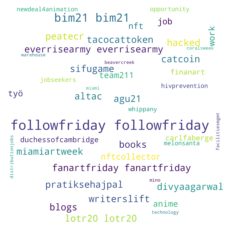

In [53]:
# Create the wordcloud object in terminal - a very rough one.
wordcloud = WordCloud(width=2000, height=2000, background_color="white").generate(text_to_dispaly)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Populating the interactive namespace from numpy and matplotlib


D:\Users\Gilkey\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['show', 'figure']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


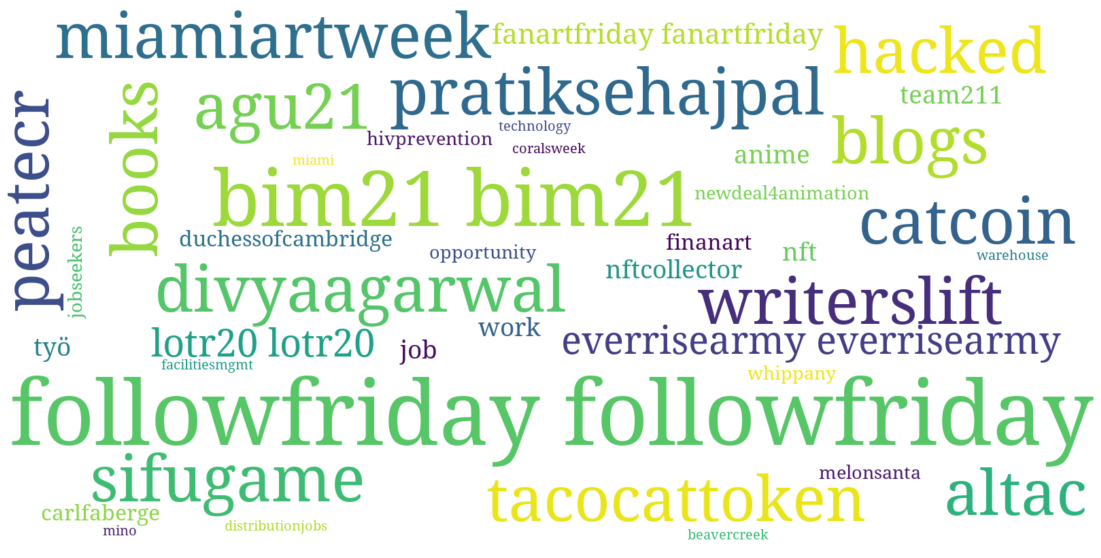

In [54]:
# This great visualization idea should credit to https://github.com/bluebluegrass/xiaoyuzhou_wordcloud/blob/main/xiaoyuzhou_wordcloud.ipynb
import matplotlib.font_manager as fm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
path = '/Fonts/NotoSerif-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size= 15)

# define your plot. width,height and others.
from wordcloud import WordCloud
wordcloud = WordCloud(font_path=location +path,width=1600, height=800, max_font_size=150, max_words=1000, background_color="white").generate(text_to_dispaly)
%pylab inline
import matplotlib.pyplot as plt
plt.figure( figsize=(20,10) )
# you will get a word cloud with the size you defined.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

#store to file
plt.savefig("cloud.png", format="png", bbox_inches='tight')

## How about we generate the hashtag total sentiments according to a "universe" image?

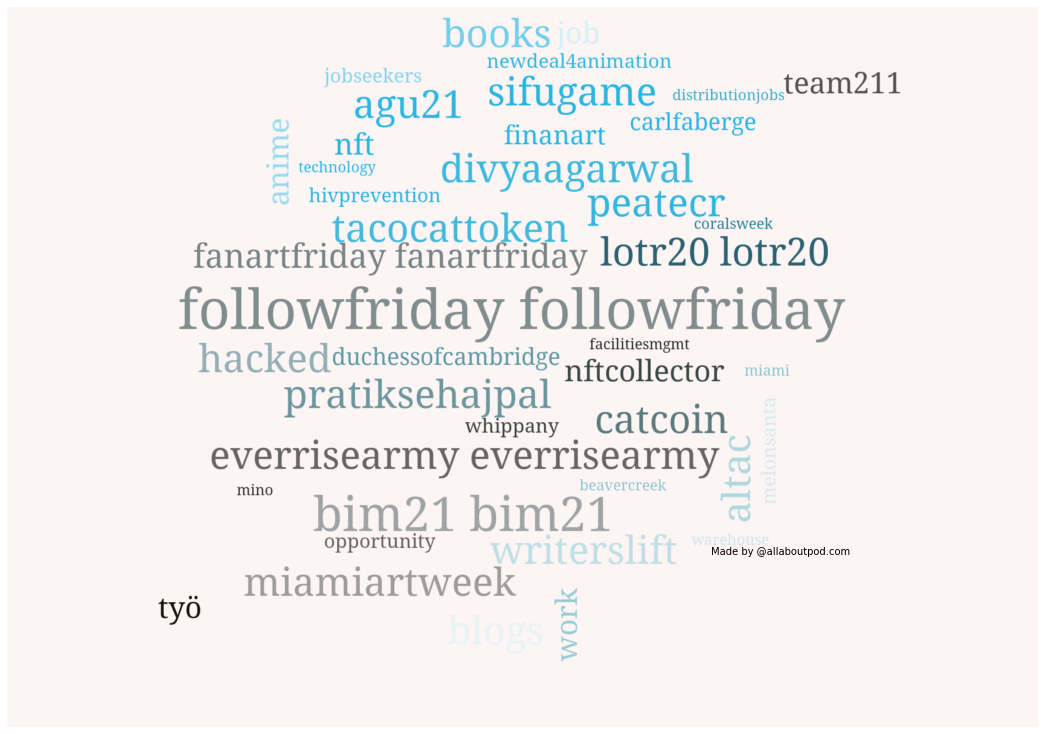

In [55]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.patches as patches

# This great visualization idea should credit to https://github.com/bluebluegrass/xiaoyuzhou_wordcloud/blob/main/xiaoyuzhou_wordcloud.ipynb
# Generate a word cloud according to an image
# You can find the image here: https://sm.ms/image/vpVzBtbJ27icFdj
# upload the image
mask = np.array(Image.open("universe.jpg"))
wordcloud_color = WordCloud(font_path=location +path, width=1600, height=800, max_font_size=150,background_color="#fdf5f4", max_words=500, mask=mask).generate(text_to_dispaly)
# create coloring from image
image_colors = ImageColorGenerator(mask)
fig = plt.figure(figsize=(20,10))

# build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

ax = fig.add_axes([0, 0, 1, 1])
ax.text(right, bottom, 'Made by @allaboutpod.com',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax.transAxes)

plt.imshow(wordcloud_color.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("wordcloud_generate.png", format="png",dpi=200,bbox_inches='tight',  pad_inches=0)
plt.show()

## It seems there are not enough hashtags to generate a clearer one. But it works!

# This Tweet sentiments analysis frame work can do much more! Please refer to the slides for more ideas and enjoy!